# Assignment 4 - Markov Decision Processes

In [22]:
import gym
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import itertools 

## Frozen lake problem

In [29]:
# testing
env = gym.make('FrozenLake8x8-v0', is_slippery=True)
observation = env.reset()
env.env.s = 62 # go to state s
s_next, r, done, info = env.step(3)
env.render()
env.close()
print("Next state: {} Reward: {} Done: {} Info: {}".format(s_next, r, done, info))

(Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Next state: 63 Reward: 1.0 Done: True Info: {'prob': 0.3333333333333333}


In [87]:
def value_iteration(env, max_iterations=100000, lmbda=0.9, verbose=1):
    stateValue = [0 for i in range(env.nS)]
    newStateValue = stateValue.copy()
    for i in range(max_iterations):
        if verbose>0: print("Iteration: {}".format(i))
        for state in range(env.nS):
            action_values = []      
            for action in range(env.nA):
                state_value = 0
                for s in range(len(env.P[state][action])):
                    prob, next_state, reward, done = env.P[state][action][s]
                    if verbose>1: 
                        print("Iteration: {} State: {} Action: {} Prob: {} Next State: {} Reward: {}".format(i, state, action, prob, next_state, reward))
                    state_action_value = prob * (reward + lmbda*stateValue[next_state])
                    state_value += state_action_value
                action_values.append(state_value)
                best_action = np.argmax(np.asarray(action_values))
                newStateValue[state] = action_values[best_action]
        if i > 1000: 
            print("Delta V: {}".format(np.max(np.abs(np.array(stateValue) - np.array(newStateValue)))))
            if np.max(np.abs(np.array(stateValue) - np.array(newStateValue))) < 0.01:
                break
            else:
                stateValue = newStateValue.copy()
    return stateValue 

In [88]:
def get_policy(env,stateValue, lmbda=0.9):
  policy = [0 for i in range(env.nS)]
  for state in range(env.nS):
    action_values = []
    for action in range(env.nA):
      action_value = 0
      for i in range(len(env.P[state][action])):
        prob, next_state, r, _ = env.P[state][action][i]
        action_value += prob * (r + lmbda * stateValue[next_state])
      action_values.append(action_value)
    best_action = np.argmax(np.asarray(action_values))
    policy[state] = best_action
  return policy 

In [89]:
def get_score(env, policy, episodes=1000):
  misses = 0
  steps_list = []
  for episode in range(episodes):
    observation = env.reset()
    steps=0
    while True:
      
      action = policy[observation]
      observation, reward, done, _ = env.step(action)
      steps+=1
      if done and reward == 1:
        # print('You have got the Frisbee after {} steps'.format(steps))
        steps_list.append(steps)
        break
      elif done and reward == 0:
        # print("You fell in a hole!")
        misses += 1
        break
  print('----------------------------------------------')
  print('You took an average of {:.0f} steps to get the frisbee'.format(np.mean(steps_list)))
  print('And you fell in the hole {:.2f} % of the times'.format((misses/episodes) * 100))
  print('----------------------------------------------')


In [90]:
stateValues = value_iteration(env, max_iterations=100000)
# policy = get_policy(env, stateValues)
# get_score(env, policy,episodes=1000)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [24]:
# the following function inspired by and adapted from: https://towardsdatascience.com/this-is-how-reinforcement-learning-works-5080b3a335d6
# using the Bellman equation, we find the action providing the highest value for the given state s. 
# V is the list of values of all states
def choose_best_action(env, V, s, gamma, verbose):
    a_best = None
    q_best = float('-inf')
    nb_actions = env.action_space.n
    for a in range (0, nb_actions):
        env.env.s = s # go to state s
        s_next, r, done, info = env.step(a) #take the action a
        if verbose > 1: print("Action: {} Reward: {}".format(a, r))
        q = r + gamma * V[s_next] # compute the value future value after taking action a
        if q > q_best:
            q_best = q
            a_best = a
            r_best = r
            s_next_best = s_next
    return a_best, r_best, s_next_best

### Value Iteration

In [26]:
# the following function inspired by and adapted from: https://towardsdatascience.com/this-is-how-reinforcement-learning-works-5080b3a335d6
# value iteration algorithm
def compute_value_iteration(
    env=gym.make('FrozenLake8x8-v0'), 
    gamma=0.9, 
    v_delta_threshold=0.001, 
    V=None, 
    verbose=1):
    env.reset()
    nb_actions = env.action_space.n
    nb_states = env.observation_space.n     
    # values vector     
    if V == None:         
        V = np.zeros([nb_states])    
    # policy vector     
    P = np.zeros([nb_states], dtype=int)
    iteration = 0
   
    while True:        
        if verbose > 0: print("Iteration: {}".format(iteration))
        v_delta = 0
        v_previous = V.copy()
        for s in range (0, nb_states):
            a_best, r_best, s_next = choose_best_action(env, V, s, gamma, verbose=verbose) # find an action with the highest future reward
            # env.env.s = s # go to the state s
            # s_next, r, done, info = env.step(a_best) #take the best action
            if verbose > 1: print("State: {} Best Action: {} Reward: {} ".format(s, a_best, r_best))
            V[s] = r_best + gamma * V[s_next] # update the value of the state
            if verbose > 1: print("Updated state value: {}".format(V[s]))
            P[s] = a_best # store the best action in the policy vector for the state
        
        # v_delta = np.max(np.abs(V-v_previous)) # calculate the rate of value improvment for the state
        v_delta = np.sum(np.abs(V-v_previous)) # calculate the rate of value improvment for the state    
        if verbose > 0: print("V_delta: {}".format(v_delta))
        iteration += 1
        if v_delta < v_delta_threshold:
            if verbose:
                if verbose > 0: print (iteration,' iterations done')
            break
    return V, P

# compute values for a 4x4 board
V, P = compute_value_iteration()

.8155765221280555
Iteration: 11870
V_delta: 3.428222455897475
Iteration: 11871
V_delta: 5.459746871074449
Iteration: 11872
V_delta: 4.489846526521952
Iteration: 11873
V_delta: 3.4856851384578436
Iteration: 11874
V_delta: 3.6847835364679584
Iteration: 11875
V_delta: 3.8833318709865567
Iteration: 11876
V_delta: 3.929601479606924
Iteration: 11877
V_delta: 4.28629405331613
Iteration: 11878
V_delta: 4.540261055641917
Iteration: 11879
V_delta: 3.7133375872861656
Iteration: 11880
V_delta: 3.577528783044862
Iteration: 11881
V_delta: 3.480221206978523
Iteration: 11882
V_delta: 3.8518886806492953
Iteration: 11883
V_delta: 3.5301110235576116
Iteration: 11884
V_delta: 3.607452549422267
Iteration: 11885
V_delta: 3.759235216001516
Iteration: 11886
V_delta: 3.5015952105068147
Iteration: 11887
V_delta: 4.008856724698955
Iteration: 11888
V_delta: 3.503299016430204
Iteration: 11889
V_delta: 3.4457642772748156
Iteration: 11890
V_delta: 3.8975118489697325
Iteration: 11891
V_delta: 3.6471144371317736
Itera

KeyboardInterrupt: 

In [92]:
def display_state_values(V, env):
    nb_states = env.observation_space.n
    V = np.round(V, decimals=4)
    ax = sns.heatmap(V.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 linewidth=0.5,
                 annot=V.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 fmt = '',
                 cbar=False)
    plt.show()

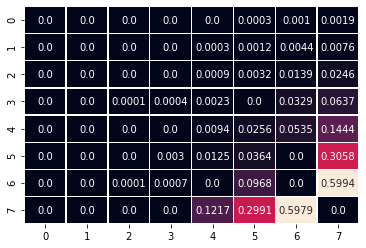

In [93]:
display_state_values(stateValues, env)
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

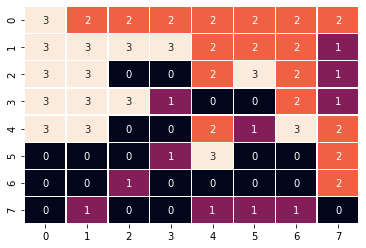

In [43]:
display_state_values(policy, env)
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

### Policy Iteration

In [60]:
# function for performing policy iteration
def compute_policy_iteration(env = gym.make('FrozenLake8x8-v0', is_slippery=False), 
                            gamma=.9, v_delta_threshold=.01,
                            P = None, verbose=2, max_iterations = 200000):
    env.reset()
    nb_actions = env.action_space.n
    nb_states = env.observation_space.n
    # values vector
    V = np.zeros([nb_states])
    # policy vector
    if P == None:
        P = np.random.choice(nb_actions, size=nb_states)
        
    iteration = 0
    for i in range(max_iterations):
        
        if verbose > 1: print("Total iterations: {}".format(iteration))
        # policy evaluation
        value_iteration = 0
        while True:
            if verbose > 1: print("Value iteration: {}".format(value_iteration))
            v_delta = 0
            v_previous = V.copy()
            for s in range (0, nb_states):
                env.env.s = s # go to state s
                s_next, r, done, info = env.step(P[s]) #take the action recommended by policy
                V[s] = r + gamma * V[s_next] # update value after applying policy
            
            v_delta = np.max(np.abs(V-v_previous)) # calculate the rate of value improvment for the state
            value_iteration += 1
            if verbose > 1: print("V_delta: {}".format(v_delta))
            print(V)
            if v_delta < v_delta_threshold:
                break

        # policy improvement
        policy_stable = True
        a_old = P.copy() # ask policy for action to perform
        for s in range (0, nb_states):
            a_best, r_best, s_next = choose_best_action(env, V, s, gamma, verbose=verbose) # find an action with the highest future reward    
            if verbose > 1: print("State: {} Best Action: {} Reward: {} ".format(s, a_best, r_best))
            P[s] = a_best # store the best action in the policy vector for the state
        
        if not np.array_equal(a_old, P):
            policy_stable = False
        
        if policy_stable:
            break
                
        iteration += 1

    if verbose > 0:
        print (iteration,' iterations done')    
    return V, P
    
V, P = compute_policy_iteration()

0 Reward: 0
Action: 1 Reward: 0
Action: 2 Reward: 0
Action: 3 Reward: 0
State: 54 Best Action: 0 Reward: 0 
Action: 0 Reward: 0.0
Action: 1 Reward: 1.0
Action: 2 Reward: 0.0
Action: 3 Reward: 0.0
State: 55 Best Action: 1 Reward: 1.0 
Action: 0 Reward: 0.0
Action: 1 Reward: 0.0
Action: 2 Reward: 0.0
Action: 3 Reward: 0.0
State: 56 Best Action: 2 Reward: 0.0 
Action: 0 Reward: 0.0
Action: 1 Reward: 0.0
Action: 2 Reward: 0.0
Action: 3 Reward: 0.0
State: 57 Best Action: 2 Reward: 0.0 
Action: 0 Reward: 0.0
Action: 1 Reward: 0.0
Action: 2 Reward: 0.0
Action: 3 Reward: 0.0
State: 58 Best Action: 3 Reward: 0.0 
Action: 0 Reward: 0
Action: 1 Reward: 0
Action: 2 Reward: 0
Action: 3 Reward: 0
State: 59 Best Action: 0 Reward: 0 
Action: 0 Reward: 0.0
Action: 1 Reward: 0.0
Action: 2 Reward: 0.0
Action: 3 Reward: 0.0
State: 60 Best Action: 2 Reward: 0.0 
Action: 0 Reward: 0.0
Action: 1 Reward: 0.0
Action: 2 Reward: 0.0
Action: 3 Reward: 0.0
State: 61 Best Action: 2 Reward: 0.0 
Action: 0 Reward: 0.

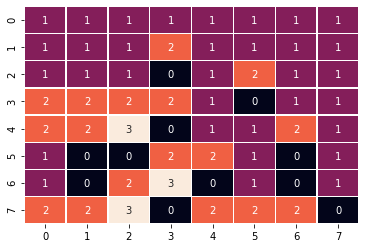

In [61]:
display_state_values(P, env)
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3

### Q-Learning

In [7]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
       
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
   
    return policyFunction 

In [20]:
def qLearning(env, num_episodes, discount_factor = 1.0, 
							alpha = 0.6, epsilon = 0.1): 
	""" 
	Q-Learning algorithm: Off-policy TD control. 
	Finds the optimal greedy policy while improving 
	following an epsilon-greedy policy"""
	
	# Action value function 
	# A nested dictionary that maps 
	# state -> (action -> action-value). 
	Q = defaultdict(lambda: np.zeros(env.action_space.n)) 

	# Keeps track of useful statistics 
	# stats = plotting.EpisodeStats( 
	# 	episode_lengths = np.zeros(num_episodes), 
	# 	episode_rewards = np.zeros(num_episodes))	 
	
	# Create an epsilon greedy policy function 
	# appropriately for environment action space 
	policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n) 
	
	# For every episode 
	for ith_episode in range(num_episodes): 
		
		# Reset the environment and pick the first action 
		state = env.reset()
		print("Episode: {}".format(ith_episode))

		for t in itertools.count(): 
			
			# get probabilities of all actions from current state 
			action_probabilities = policy(state)
			print("T: {}".format(t))

			# choose action according to 
			# the probability distribution 
			action = np.random.choice(np.arange( 
					len(action_probabilities)), 
					p = action_probabilities)
			print("Action: {}".format(action)) 

			# take action and get reward, transit to next state 
			next_state, reward, done, _ = env.step(action)
			print("Next state: {} Reward: {} Done: {}".format(next_state, reward, done))

			# Update statistics 
			# stats.episode_rewards[i_episode] += reward 
			# stats.episode_lengths[i_episode] = t 
			
			# TD Update 
			best_next_action = np.argmax(Q[next_state])	 
			td_target = reward + discount_factor * Q[next_state][best_next_action] 
			td_delta = td_target - Q[state][action] 
			Q[state][action] += alpha * td_delta 

			# done is True if episode terminated 
			if done: 
				break
				
			state = next_state 
	
	return Q 


In [21]:
Q = qLearning(env, 1000)

 0.0 Done: False
T: 139
Action: 2
Next state: 17 Reward: 0.0 Done: False
T: 140
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 141
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 142
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 143
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 144
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 145
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 146
Action: 2
Next state: 17 Reward: 0.0 Done: False
T: 147
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 148
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 149
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 150
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 151
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 152
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 153
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 154
Action: 0
Next state: 16 Reward: 0.0 Done: False
T: 155
Action: 1
Next state: 24 Reward: 0.0 Done: False
T: 156
Action: 0
Next state: 24

KeyboardInterrupt: 

In [27]:
print(Q)

defaultdict(<function qLearning.<locals>.<lambda> at 0x1a1c112510>, {0: array([0., 0., 0., 0.]), 1: array([0., 0., 0., 0.]), 8: array([0., 0., 0., 0.]), 16: array([0., 0., 0., 0.]), 24: array([0., 0., 0., 0.]), 25: array([0., 0., 0., 0.]), 32: array([0., 0., 0., 0.]), 33: array([0., 0., 0., 0.]), 17: array([0., 0., 0., 0.]), 9: array([0., 0., 0., 0.]), 2: array([0., 0., 0., 0.]), 40: array([0., 0., 0., 0.]), 48: array([0., 0., 0., 0.]), 56: array([0., 0., 0., 0.]), 57: array([0., 0., 0., 0.]), 41: array([0., 0., 0., 0.]), 26: array([0., 0., 0., 0.]), 10: array([0., 0., 0., 0.]), 49: array([0., 0., 0., 0.]), 18: array([0., 0., 0., 0.]), 3: array([0., 0., 0., 0.]), 19: array([0., 0., 0., 0.]), 34: array([0., 0., 0., 0.]), 42: array([0., 0., 0., 0.])})
